In [1]:
!nvidia-smi

Sun Feb  2 09:02:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


preparing dataset

In [3]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128  # Reduced batch size
EPOCHS = 50
noise_dim = 100

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

creating the model

In [7]:
def make_generator_model():
    model = tf.keras.Sequential([
        # Input layer
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),

        # First upsampling block
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Second upsampling block
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Output layer
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

In [9]:
# Initialize models
generator = make_generator_model()
discriminator = make_discriminator_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss and optimizer

In [10]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
# Optimizers with adjusted learning rates
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

training loop

In [14]:
# Training step with progress tracking
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [15]:
def train(dataset, epochs):
    gen_losses = []
    disc_losses = []

    # Progress bar
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Track batch progress
        batch_gen_losses = []
        batch_disc_losses = []
        num_batches = len(list(dataset))

        for batch_idx, image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)
            batch_gen_losses.append(gen_loss.numpy())
            batch_disc_losses.append(disc_loss.numpy())

            # Print progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                print(f"Batch {batch_idx + 1}/{num_batches} - "
                      f"Gen Loss: {np.mean(batch_gen_losses):.4f}, "
                      f"Disc Loss: {np.mean(batch_disc_losses):.4f}")

        # Store epoch losses
        gen_losses.append(np.mean(batch_gen_losses))
        disc_losses.append(np.mean(batch_disc_losses))

    return gen_losses, disc_losses

In [16]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [17]:
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

training the model

In [18]:
# Train the model
gen_losses, disc_losses = train(train_dataset, EPOCHS)




Epoch 1/50
Batch 50/469 - Gen Loss: 0.5830, Disc Loss: 1.2179
Batch 100/469 - Gen Loss: 0.6153, Disc Loss: 1.2828
Batch 150/469 - Gen Loss: 0.6444, Disc Loss: 1.2915
Batch 200/469 - Gen Loss: 0.6612, Disc Loss: 1.2994
Batch 250/469 - Gen Loss: 0.6729, Disc Loss: 1.3061
Batch 300/469 - Gen Loss: 0.6827, Disc Loss: 1.3118
Batch 350/469 - Gen Loss: 0.6892, Disc Loss: 1.3175
Batch 400/469 - Gen Loss: 0.6944, Disc Loss: 1.3225
Batch 450/469 - Gen Loss: 0.6981, Disc Loss: 1.3252

Epoch 2/50
Batch 50/469 - Gen Loss: 0.7314, Disc Loss: 1.3534
Batch 100/469 - Gen Loss: 0.7294, Disc Loss: 1.3515
Batch 150/469 - Gen Loss: 0.7330, Disc Loss: 1.3511
Batch 200/469 - Gen Loss: 0.7339, Disc Loss: 1.3485
Batch 250/469 - Gen Loss: 0.7366, Disc Loss: 1.3510
Batch 300/469 - Gen Loss: 0.7377, Disc Loss: 1.3477
Batch 350/469 - Gen Loss: 0.7385, Disc Loss: 1.3472
Batch 400/469 - Gen Loss: 0.7409, Disc Loss: 1.3455
Batch 450/469 - Gen Loss: 0.7434, Disc Loss: 1.3434

Epoch 3/50
Batch 50/469 - Gen Loss: 0.764

visualising images from generator

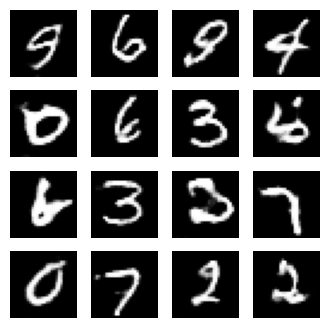

In [19]:
# Final generation and visualization
generate_and_save_images(generator, EPOCHS, seed)

plotting losses

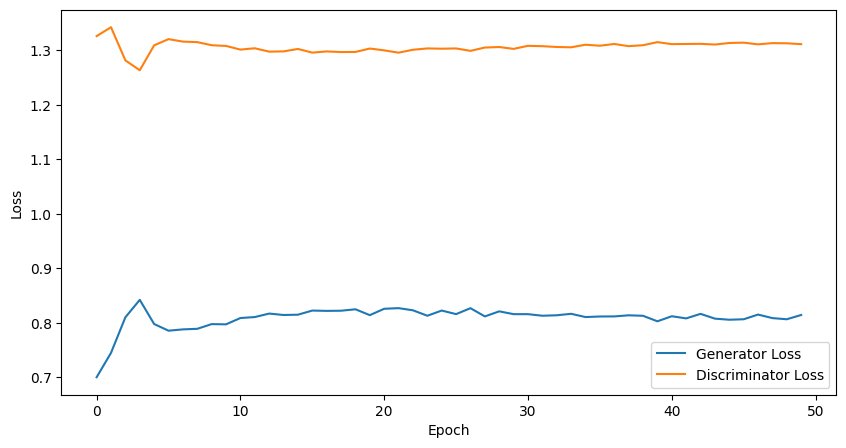

In [20]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

minimum losses

In [21]:
print(f"minimum loss for generator is {min(gen_losses)}")
print(f"minimum loss for discriminator is {min(disc_losses)}")

minimum loss for generator is 0.7004441618919373
minimum loss for discriminator is 1.2633113861083984
